### Importing libraries

In [74]:
import pandas as pd
import json
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
%matplotlib inline

#### BK data

In [26]:
bk_data = pd.read_json('BK_locations.json')
bk_data.drop(['storeId', 'closed', 'premium'], inplace=True, axis=1)
print(len(bk_data))
bk_data.head()

752


,latitude,longitude
0,50.632401,36.571400
1,53.378700,58.981602
2,55.790255,37.679944
3,55.756184,37.615438
4,55.770393,37.620663


In [34]:
# Make sure that all data are numbers
bk_data.dtypes

latitude     float64
longitude    float64
dtype: object

#### Working with KFC data

In [6]:
with open('KFC_locations_2.json', encoding='utf-8') as f:
    data = json.load(f)

In [7]:
stores = []
for city in data['value']['cities']:
    data_2 = json.dumps(city)
    stores.append(data_2)

In [8]:
stores[0]

'{"kfcCityId": "bc9b73b2-46de-48b2-bfae-36aa867beeb6", "externalIdentifiers": {"deliveryUrl": "https://trk.mail.ru/c/u7pej0", "deliveryUrlMobile": "https://trk.mail.ru/c/u7pej0", "maxMindGeoNameID": null, "oldSiteId": "11"}, "title": {"en": "Novosibirsk", "ru": "\\u041d\\u043e\\u0432\\u043e\\u0441\\u0438\\u0431\\u0438\\u0440\\u0441\\u043a"}, "timezone": "Asia/Novosibirsk", "utc": "+07:00", "country": "RU", "defaultStore": {"id": "74213285", "coordinates": {"type": "Feature", "geometry": {"type": "Point", "coordinates": [55.041418, 82.912743]}, "properties": {"name": {"en": "KFC Lepestok Novosibirsk", "ru": "KFC \\u041b\\u0435\\u043f\\u0435\\u0441\\u0442\\u043e\\u043a \\u041d\\u043e\\u0432\\u043e\\u0441\\u0438\\u0431\\u0438\\u0440\\u0441\\u043a"}}}}, "delivery": true, "clickCollect": true, "allowClickCollect": true}'

#### Receiving coodrinates for each point

In [9]:
coordinates = []
for store in stores:
    spl_word = '"coordinates": ['
    res = store.partition(spl_word)[2] 
    split_string = res.split("]", 1)
    substring = split_string[0]
    coordinates.append(substring)

In [13]:
latitude_kfc = []
for coord in coordinates:
    if (coord.split(', ', 1)[-1] == ''):
        latitude_kfc.append('null')
    else:
        latitude_kfc.append(coord.split(', ', 1)[0])
    
longitude_kfc = []
for coord in coordinates:
    if (coord.split(', ', 1)[-1] == ''):
        longitude_kfc.append('null')
    else:
        longitude_kfc.append(coord.split(', ', 1)[-1])

In [15]:
kfc_data = pd.DataFrame({'latitude': latitude_kfc, 'longitude': longitude_kfc})
print(len(kfc_data))
kfc_data.head()

195


,latitude,longitude
0,55.041418,82.912743
1,55.616248,36.987898
2,47.291422,39.846595
3,56.321581,36.554344
4,0.0,0.0


In [36]:
# Make sure that all data are numbers
kfc_data.dtypes
# No, it is not

latitude     object
longitude    object
dtype: object

In [46]:
kfc_data = kfc_data[kfc_data.latitude != 'null']

In [47]:
kfc_data.latitude = kfc_data['latitude'].astype(float)
kfc_data['longitude'] = kfc_data['longitude'].astype(float)

In [95]:
kfc_data.head()

,latitude,longitude
0,55.041418,82.912743
1,55.616248,36.987898
2,47.291422,39.846595
3,56.321581,36.554344
4,0.000000,0.000000


#### Create shapely Points from lat/long

In [27]:
bk_data

,latitude,longitude
0,50.632401,36.571400
1,53.378700,58.981602
2,55.790255,37.679944
3,55.756184,37.615438
4,55.770393,37.620663
...,...,...
747,55.780588,37.667348
748,56.852933,35.907664
749,56.315701,43.992252
750,57.786957,40.920807


In [31]:
# Create shapely Points from lat/long and confirming for the geodataframe that we're using lat/long
points_bk = bk_data.apply(lambda row: Point(row.longitude, row.latitude), axis=1)
points_bk.crs = {'init': 'epsg:4326'}

In [49]:
points_kfc = kfc_data.apply(lambda row: Point(row.longitude, row.latitude), axis=1)
points_kfc.crs = {'init': 'epsg:4326'}

In [50]:
len(points_bk)

752

In [51]:
len(points_kfc)

192

In [58]:
distance = 0.2 # Radius 2 km in epsg:4326
count_of_kfc_per_bk = [] # Stores count of KFC for each BK in range 2 km
for point_bk in points_bk: # For current BK
    count = 0 # Count of KFC competitors for current BK in range 2 km
    for point_kfc in points_kfc: # For current KFC 
        circle_buffer = point_bk.buffer(distance)  # Create a circle around current BK
        if point_kfc.within(circle_buffer): # And if current KFC within range
            count += 1 # +1 competitor KFC for BK
    count_of_kfc_per_bk.append(count)

In [59]:
len(count_of_kfc_per_bk)

752

In [77]:
bk_concurents = pd.DataFrame({'longitude': bk_data.longitude, 'latitude': bk_data.latitude, 'KFCs around 2 kms': count_of_kfc_per_BK})
bk_concurents

,longitude,latitude,KFCs around 2 kms
0,36.571400,50.632401,1
1,58.981602,53.378700,1
2,37.679944,55.790255,2
3,37.615438,55.756184,2
4,37.620663,55.770393,2
...,...,...,...
747,37.667348,55.780588,2
748,35.907664,56.852933,1
749,43.992252,56.315701,1
750,40.920807,57.786957,1


In [79]:
gdf = gpd.GeoDataFrame(bk_concurents, geometry=points_bk)
gdf

,longitude,latitude,KFCs around 2 kms,geometry
0,36.571400,50.632401,1,POINT (36.57140 50.63240)
1,58.981602,53.378700,1,POINT (58.98160 53.37870)
2,37.679944,55.790255,2,POINT (37.67994 55.79026)
3,37.615438,55.756184,2,POINT (37.61544 55.75618)
4,37.620663,55.770393,2,POINT (37.62066 55.77039)
...,...,...,...,...
747,37.667348,55.780588,2,POINT (37.66735 55.78059)
748,35.907664,56.852933,1,POINT (35.90766 56.85293)
749,43.992252,56.315701,1,POINT (43.99225 56.31570)
750,40.920807,57.786957,1,POINT (40.92081 57.78696)


In [81]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

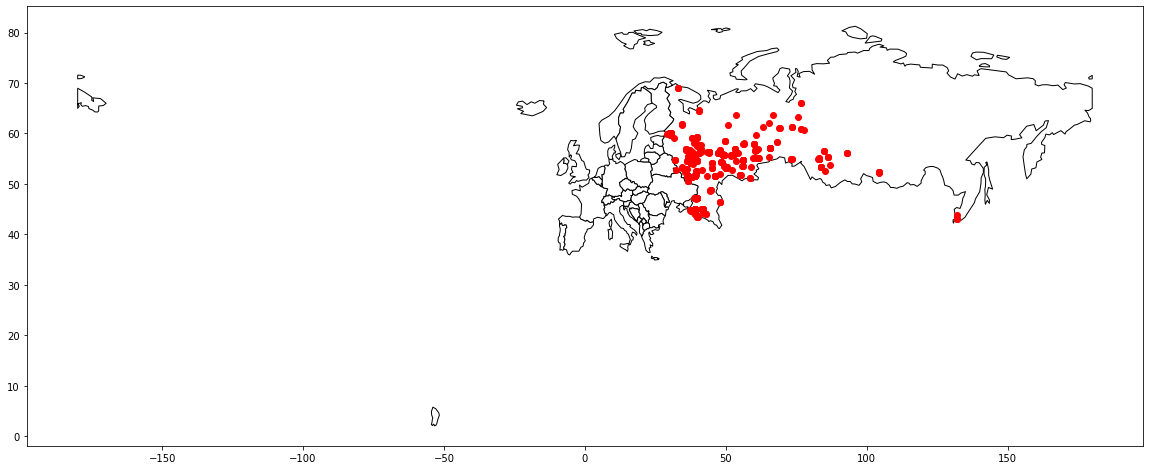

In [94]:
ax = world[world.continent == 'Europe'].plot(
    color='white', edgecolor='black', figsize=(20,20))

gdf.plot(ax=ax, color='red')

plt.show()